In [1]:
import os
import pandas as pd # table management
import numpy as np
import matplotlib.pyplot as plt # General graphs
import seaborn as sns # For advanced visualizations

In [2]:
def get_class_paths(path):
    classes = []
    class_paths = []
    # Iterate through directories in the training path
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        # Check if it's a directory
        if os.path.isdir(label_path):
            # Iterate through images in the label directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                # Add class and path to respective lists
                classes.append(label)
                class_paths.append(image_path)
    # Create a DataFrame with the collected data
    df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return df

In [3]:
df_tr = get_class_paths("Training")
df_tr

,Class Path,Class
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


In [4]:
df_ts = get_class_paths("Testing")
df_ts

,Class Path,Class
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


In [5]:
full_dataset_size = len(df_ts.index) + len(df_tr.index)
"Size of dataset: {}".format(full_dataset_size)

'Size of dataset: 7023'

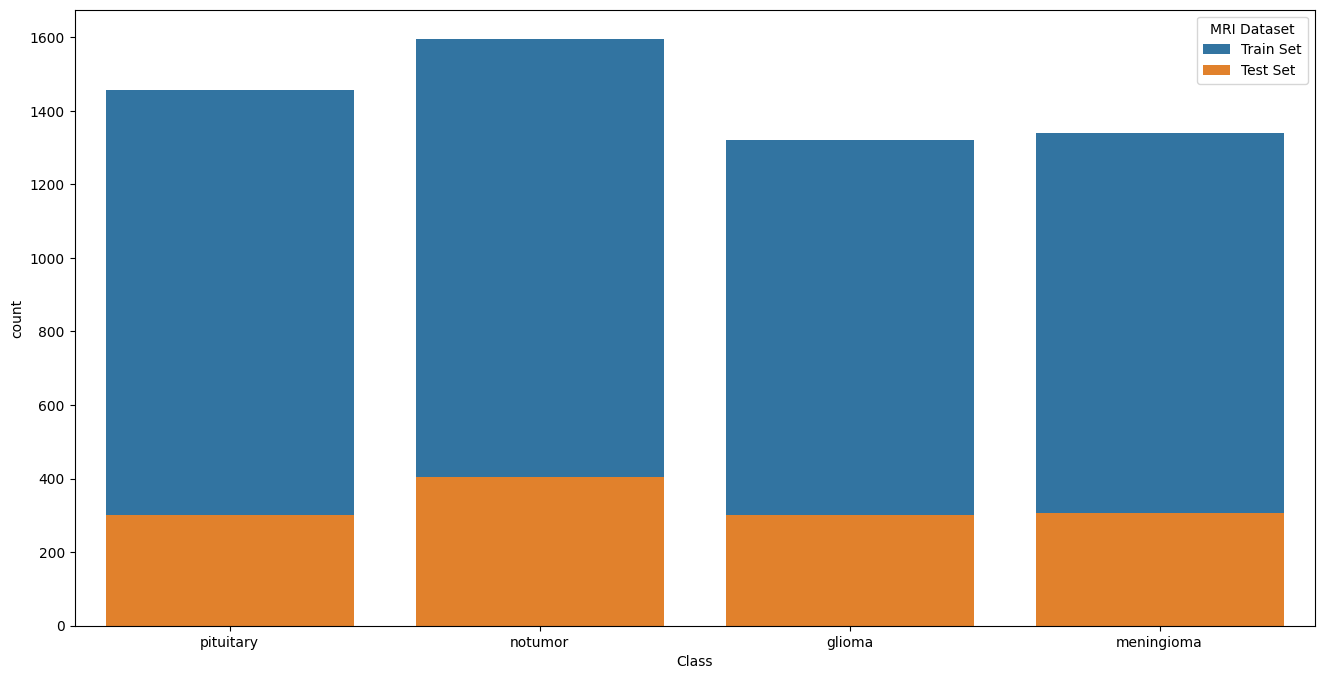

In [6]:
plt.figure(figsize=[16,8])
# Plot the first countplot
ax = sns.countplot(data=df_tr, x='Class', label='Train Set')

# Plot the second countplot
ay = sns.countplot(data=df_ts, x='Class', label='Test Set')
plt.legend(title="MRI Dataset")

Dataset is relatively even, may need to find a way to even them all just in case

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps, ImageFilter # Image manpulation libraries for my own implementations

2024-11-16 10:44:28.428236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Same thing as before. Instructor used 0.5 of split, I'll use 0.7 split like last project

In [8]:
valid_df, df_ts = train_test_split(df_ts, train_size=0.5, stratify=df_ts['Class'])  # stratisfy makes sure that each label in the training is the same size
valid_df



,Class Path,Class
1114,Testing/meningioma/Te-me_0198.jpg,meningioma
56,Testing/pituitary/Te-pi_0236.jpg,pituitary
1141,Testing/meningioma/Te-me_0161.jpg,meningioma
378,Testing/notumor/Te-no_0320.jpg,notumor
96,Testing/pituitary/Te-pi_0286.jpg,pituitary
...,...,...
173,Testing/pituitary/Te-pi_0297.jpg,pituitary
591,Testing/notumor/Te-no_0216.jpg,notumor
638,Testing/notumor/Te-no_0073.jpg,notumor
138,Testing/pituitary/Te-pi_0121.jpg,pituitary


In [9]:
"Testing Dataframe"
df_ts

,Class Path,Class
417,Testing/notumor/Te-no_0041.jpg,notumor
945,Testing/glioma/Te-gl_0065.jpg,glioma
75,Testing/pituitary/Te-pi_0287.jpg,pituitary
946,Testing/glioma/Te-gl_0273.jpg,glioma
381,Testing/notumor/Te-no_0297.jpg,notumor
...,...,...
32,Testing/pituitary/Te-pi_0190.jpg,pituitary
803,Testing/glioma/Te-gl_0032.jpg,glioma
981,Testing/glioma/Te-gl_0088.jpg,glioma
1107,Testing/meningioma/Te-me_0238.jpg,meningioma


Preprocessing


In [31]:
from math import sqrt
batch_size = 64 # Instructor used 32, im using a weird number
smaller_batch = batch_size//2
img_size = (300,300)
smaller_batch

32

Resize images so all images follow a standarized format. Since I had a bit of experience on doing that i am using a bunch of functions that will generate a whole new batch of photos. The idea of this is that i want to compare the implementation taught at headstarter and the implementation I learned on my own before the program.

In [12]:
def crop_square_img(path, export=True):
    img = Image.open(path)
    width, height = img.width, img.height
    side = min(width, height)
    left = int(np.ceil((width - side) / 2))
    right = width - int(np.floor((width - side) / 2))
    top = int(np.ceil((height - side) / 2))
    bottom = height - int(np.floor((height - side) / 2))

    img_cropped = img.crop((left, top, right, bottom))

    print(
        f"""Image Report: 
    Format: {img_cropped.format})
    Mode: {img_cropped.mode}
    """
    )
    if export:
        img_cropped.save("somepic-test-{}.jpg".format(img_cropped.size))
    return img_cropped

In [73]:
# Create a copy folder where all images are of square size and resized to some pixel number
def resize_img(path, mode, base_width=256, percentage=10, export=True, export_path_folder="Preprocessed", export_base_filename="glioma"):
    # mode is either pixel or percentage
    perc = percentage / 100
    img = Image.open(path)
    if mode == "pixels":
        wpercent = base_width / (img.size[0])
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
        img_transpose = ImageOps.exif_transpose(img)
        if export:
            img_transpose.save("{}/{}-{}.jpg".format(export_path_folder, export_base_filename, img.size))
        return img_transpose
    elif mode == "percentage":
        img = img.resize([int(perc * s) for s in img.size], Image.Resampling.LANCZOS)
        img_transpose = ImageOps.exif_transpose(img)
        if export:
            img_transpose.save("{}/{}-{}.jpg".format(export_path_folder, export_base_filename, img.size))
        return img_transpose
    else:
        return None

Implementation taught in Headstarter

In [26]:
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=[0.8, 1.2])
ts_gen = ImageDataGenerator(rescale=1/255) # 255? 

In [27]:
tr_gen = image_generator.flow_from_dataframe(
    df_tr,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

ts_gen = ts_gen.flow_from_dataframe(
    df_ts,
    x_col='Class Path',
    y_col='Class',
    batch_size=smaller_batch,
    target_size=img_size,
    shufle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

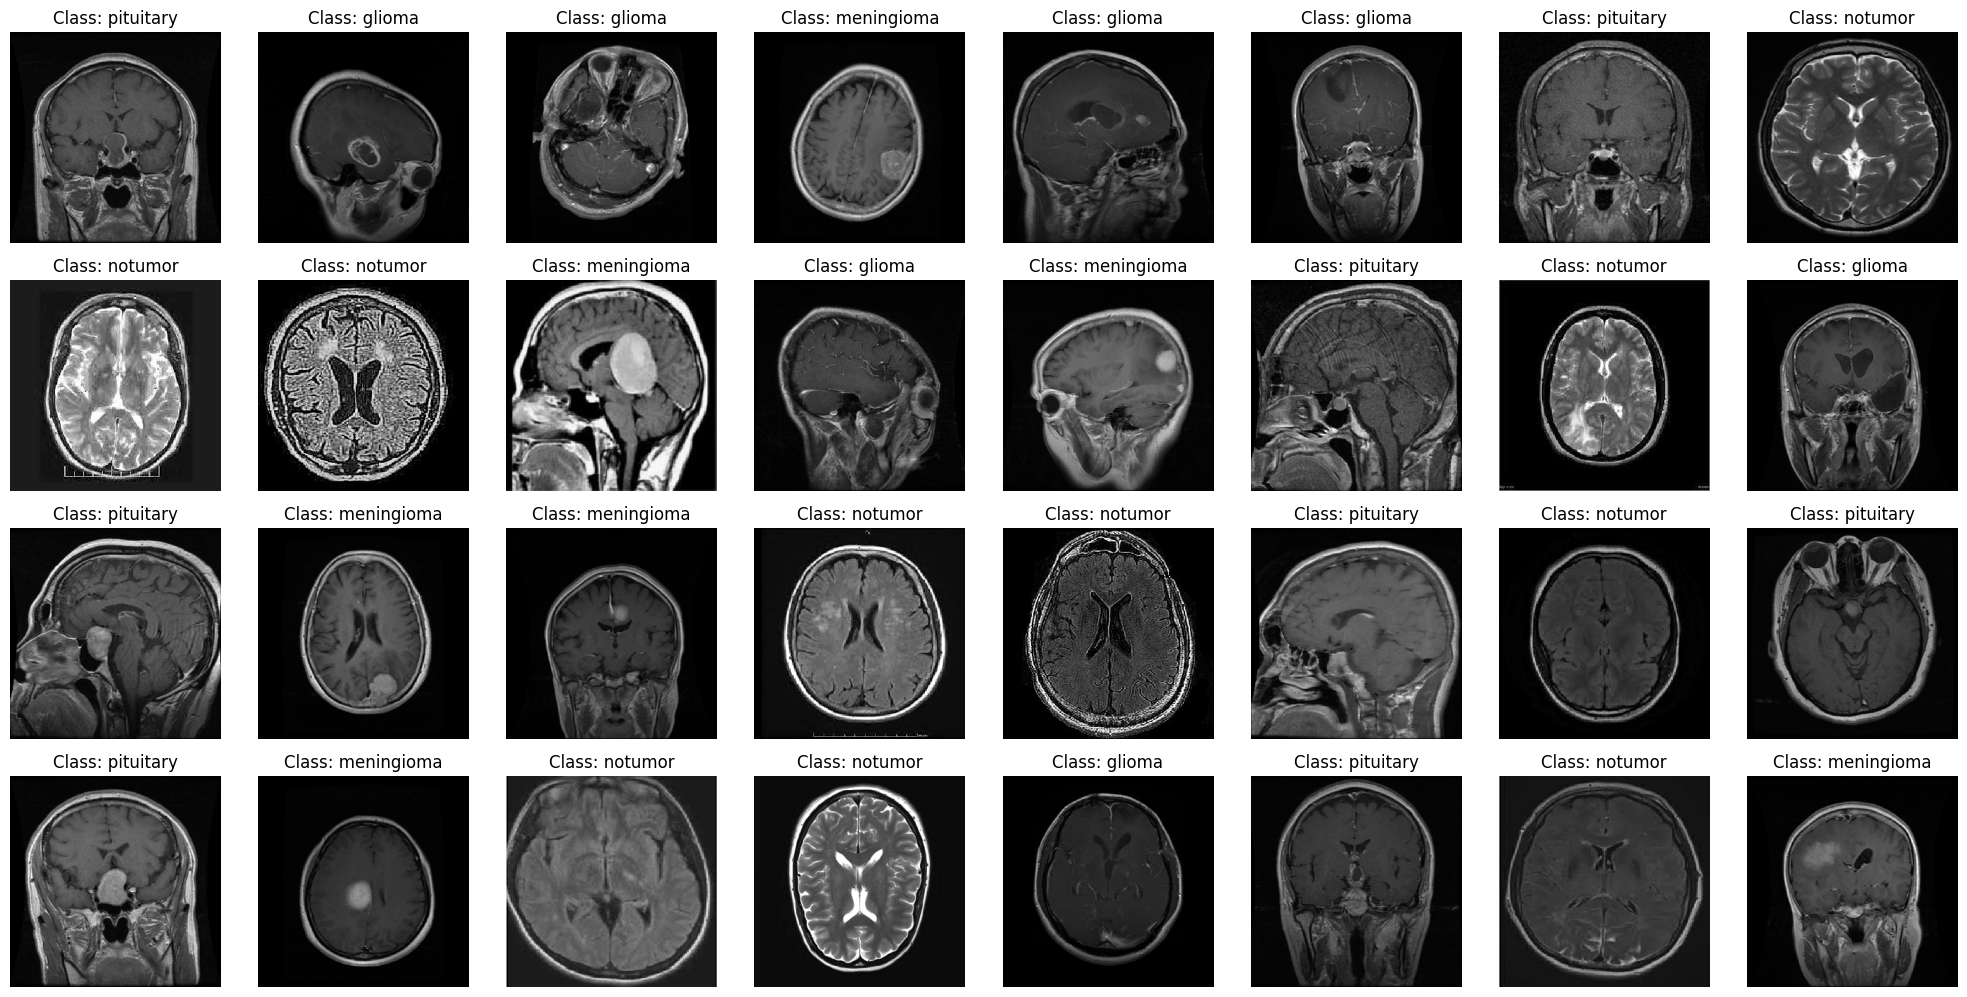

In [32]:
plt. figure(figsize=(20, 20)) 
for i in range (smaller_batch):
    plt. subplot (int(sqrt(batch_size)), int(sqrt(batch_size)), i+1)
    batch = next(tr_gen)
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)
    
    # class Index
    class_index = np.argmax(label) # Returns the indices of the maximum values along an axis.
    
    class_names = list(tr_gen.class_indices.keys())
    class_indices = list(tr_gen.class_indices.values())
    
    index_position = class_indices.index(class_index)
    
    class_name = class_names[index_position]
    
    plt.title(f"Class: {class_name}")
    plt.axis("off")
plt.tight_layout()
plt.show
    

Xception Model

Developed by Francois Chollet at Google. Short for Extreme Inception, a convolutional neural network. Used for image recognition.

The inception architecture uses inception modules, however the Xception model replaces it with depthwise separable convolution layers, which totals 36 layers. When we compare the xception model with the Inception V3 model, it performs a bit better on the ImageNet dataset. On larger datasets of 350M images Xception performs much better.

The first ones was AlexNet, if i have time i wanna try it

Xception works by breaking down the image into smaller, easier-to-understand parts, and then looks at those parts one by one.

Just like if you were to focus on parts of an animal like the fur, the eyes, paws or tail before deciding what animal you're looking at is.


Xception was trained on ImageNet, a large and popular dataset in Computer Vision. ImageNet contains over 14M images categorized into 1k different categories. These images include everything from animals like dogs and cats to objects like cars, and plants. Its believed this dataset is the one that sparked the deep learning revolution because it allwowed it for much more sophisticated models to be released that were trained on this dataset.

Training Process:

The model was shown millions of images from the ImageNet data set, and for each image, it was told what the object in the image was. Over time, Xception learned the patterns and features that distinguish different objects like stripes of a tiger or the circular shape of a car's tire.

The training process involces a lot of trial and error. In the beginning, the model might make mistakes, but after each mistake, it adjusts or leans a little bit to improve its accuracy. This is done using a process called backpropagation and optimization techniques like Stochastic Gradient Descent (SGD).

The xception model uses backpropagation and gradient descent

transfer learning - using a pretrained model and adapting it for a different task





In [52]:
import requests

weights_url="https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_folder="weights"
weight_path=f"{weights_folder}/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
if not os.path.exists(weight_path):
    if not os.path.exists(weights_folder):
        os.makedirs(weights_folder)
    try:
        print("Downloading weights...")
        response = requests.get(weights_url, stream=True)
        with open(weight_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Weights downloaded successfully!")
    except Exception as e:
        print(f"Failed to download weights: {e}")
        exit(1)

Weights downloaded successfully!


In [54]:
img_shape = (300,300,3) # width, height rgb format


# XEPTION MODEL
base_model = tf.keras.applications.Xception(
    include_top=False, # using the model for transfer learning, but adding a classification layer on top of it
    weights=weight_path, # use imageNet dataset weights
    input_shape=img_shape,
    pooling='max' # smart summarizer, focus on most important features, faster processing
)
 
model = Sequential(
     [base_model, 
      Flatten(),
      Dropout(rate=0.3), # Prevent overfitting
      Dense(128, activation='relu'), # Number of Neurons, relu helps learn non-linear relationships
      Dropout(rate=0.25), 
      Dense(4, activation='softmax') # Out Neurons, transform output of prev layer and transforms into probability distribution over the classes
    ])



adamax is an optimizer, like a smart assistant for the training of the model

it helps the model learn by adjusting how big of steps it takes when its updating its knoledge and the weights of the model.

its like an aid that tells you how big your steps on a hill on a hike should be

categorical entropy

In [ ]:
model.compile(
    Adamax(learning_rate=0.001), # standard starting point
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', # acc of correct presicion
        Precision(), # % of true positives
        Recall() # percentage of true positives that were correctly predicted
    ]
)

learning rate is low cuz that way the model takes smaller steps but its more accurate, but also becomes slower. 

pic goes here